In [1]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import opendatasets as od

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [3]:
train_data_dir = "/Users/gihansavinda/Desktop/Projects/Machine_Leraning/Animal_identify/Dataset/train"
test_data_dir = "/Users/gihansavinda/Desktop/Projects/Machine_Leraning/Animal_identify/Dataset/test"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 6891 files belonging to 4 classes.
Using 6202 files for training.
Found 6891 files belonging to 4 classes.
Using 689 files for validation.
Found 592 files belonging to 4 classes.


In [4]:
class_names = train_data.class_names
class_names

['elephant', 'none', 'peacock', 'wildboar']

In [5]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


2024-05-12 21:05:28.146311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-05-12 21:05:29.319623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


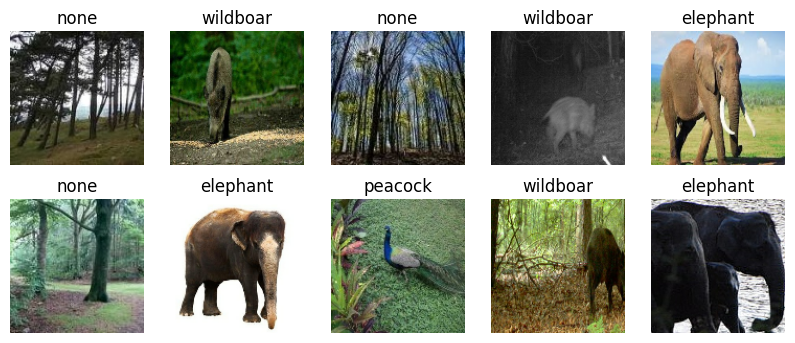

In [6]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

### Scaling Images

In [7]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

### Transfer Learning

In [8]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False

### Model Building

In [9]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=512, activation='relu'))

model.add(tf.keras.layers.Dense(units=256, activation='relu'))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dense(units=32, activation='relu'))

model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

### Model Training

In [12]:
start_time = time.time()

history = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

end_time = time.time()

Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 81s 407ms/step - accuracy: 0.8734 - loss: 0.3525 - val_accuracy: 0.9536 - val_loss: 0.1218
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 90s 463ms/step - accuracy: 0.9609 - loss: 0.1090 - val_accuracy: 0.9652 - val_loss: 0.1075
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 95s 490ms/step - accuracy: 0.9665 - loss: 0.0972 - val_accuracy: 0.9608 - val_loss: 0.1079
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.9770 - loss: 0.0753 - val_accuracy: 0.9550 - val_loss: 0.1691
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 98s 507ms/step - accuracy: 0.9798 - loss: 0.0614 - val_accuracy: 0.9608 - val_loss: 0.1116


In [13]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 461.065 seconds


### Performance Analysis

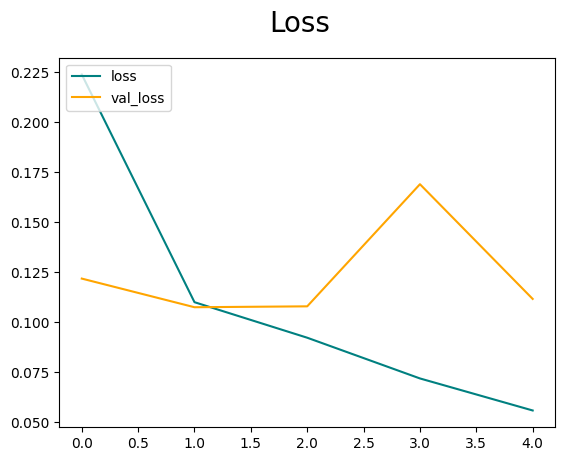

In [14]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

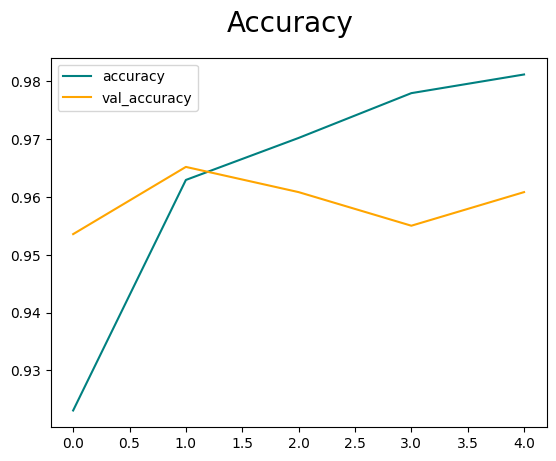

In [15]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Model Evaluation

In [16]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()

In [18]:
for batch in test_data.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=4)
    #precision.update_state(y, yhat)
    #recall.update_state(y, yhat)
    #accuracy.update_state(y, yhat)
    precision.update_state(y_onehot, yhat)
    recall.update_state(y_onehot, yhat)
    accuracy.update_state(y_onehot, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


2024-05-12 21:14:31.639338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9319728>

In [20]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9256757>

In [21]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9290541>

In [22]:
model.save('model.keras')

In [23]:
model.save('model.h5')

ValueError: Unable to create dataset (name already exists)